# Hackathon 1: simulations, descriptive stats & estimation

This project illustrates the course LEPL1109 with an industrial applications of simulations. You will analyse the performance of an assembly chain, analytically and with simulations. This is an introduction to supply chain management which is a field actively studied by engineers (see e.g. LINMA2470 Stochastic modelling). 

## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Simon Delvaux

Part. 2: Cédric Ponsard

Part. 3: Baptiste Sambon

Part. 4: Eliott Van Dieren

Part. 5: Romain Van Hauwaert

Part. 6: Maxime Vanliefde

In a manufacture of mechanical devices for the automotive industry, the production of a gearbox is done by a line of 3 successive working stations. The production of a new gearbox starts only when the previous one is fully assembled. In what follows, the assembly time of one gearbox is denoted by $T$. Also, $T_k$ is the assembly time at machine $k$. Finally $\mu_k = \mathbb{E}(T_k)$ and $\sigma^2_k = \mathbb{V}(T)$. Details about the production line are provided in the graph below.

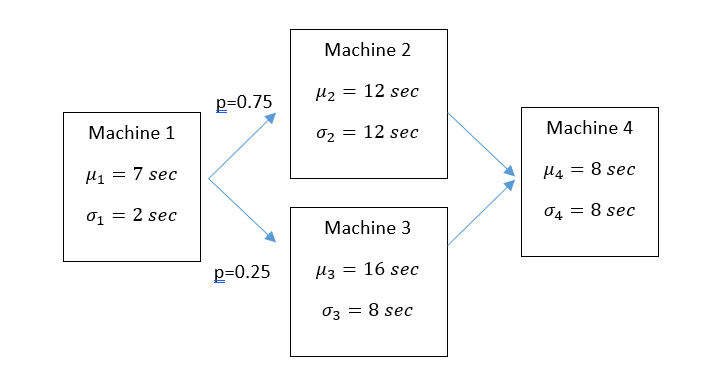

where $p=0.75$ indicates for example that the output of machine 1 ends up in machine 2 with probability $0.75$. 

------------------------------------------------------------------------------------------------------

1.	For each machine $k$, choose a (non-Gaussian) statistical distribution for the assembly time $T_k$ and provide value(s) for its parameter(s).

------------------------------------------------------------------------------------------------------

On sait déjà que les durées d'utilisation doivent être positives. On peut penser aux fonctions gamma (2 df) ainsi qu'aux exponentielles (1 df) ou au Chi-square (1 df). Or, les exponentielles et les chi-square sont des cas particuliers de distribution gamma où $\alpha = 1$ pour les exponentielles et $\alpha = v/2$ et $\beta = 2$ pour les chi-square. Les machines 1 et 3 peuvent donc être décrites par des fonctions gamma et les machines 2 et 4, dont l'espérance et la variance sont égales, peuvent être modélisées par des exponentielles.

Fonction de densité d'une distribution exponentielle : $f(x) = \frac{1}{\beta}e^{-\frac{x}{\beta}}$

Fonction de densité d'une distribution Gamma : $f(x) = \frac{1}{\Gamma(\alpha_k) \beta_k^{\alpha_k}} x^{\alpha_k - 1} e^{\frac{x}{\beta_k}}$

$\alpha_k \beta_k = \mathbb{E}(T_k)$ et $\alpha_k \beta_k^2 = \mathbb{V}(T_k)$

* $T_1$ ~ $\Gamma(\frac{49}{4},\frac{4}{7})$
* $T_2$ ~ $expo(12)$
* $T_3$ ~ $\Gamma(4,4)$
* $T_4$ ~ $expo(8)$

------------------------------------------------------------------------------------------------------------------------

b) Calculate the expected time for assembling one gearbox, $\mathbb{E}(T)$.

------------------------------------------------------------------------------------------------------------------------

Nous pouvons observer par linéarité que $\mathbb{E}(T)$ = $\mathbb{E}(T_1) + 0.75\mathbb{E}(T_2) + 0.25\mathbb{E}(T_3) + \mathbb{E}(T_4) = 7+0.75*12 + 0.25*16+8 = 28 [s]$

------------------------------------------------------------------------------------------------------

2. Simulate 5000 durations  $T$  for assembling one single gearbox and report the mean (check that its is well close to the expectation of question 1), standard deviation, 5% and 95% percentile. Plot an histogram. Save the simulated durations in a file "sample.csv".

------------------------------------------------------------------------------------------------------

In [170]:
import scipy.stats as sc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [171]:
T = np.zeros(5000)

M1a = 49/4
M1scale = 4/7
M2scale = 12
M3a = 4
M3scale = 4
M4scale = 8

for i in range(5000):
    second_m = random.choices([0,1], weights=[0.25,0.75])[0] # 1 if 2nd machine, 0 otherwise 
    T[i] = sc.gamma.rvs(a = M1a,scale = M1scale,size=1) \
           + second_m*sc.expon.rvs(scale=M2scale) \
           + (1-second_m)*sc.gamma.rvs(a = M3a,scale = M3scale,size=1) \
           + sc.expon.rvs(scale=M4scale)

fifthPercentile_T = np.quantile(T,q=0.05)
nightyfifthPercentile_T = np.quantile(T,q=0.95)
std_T = np.std(T)

print("Moyenne calculée = {} [s]".format(np.mean(T)))
print("Pourcentile 5% = {} [s]".format(fifthPercentile_T))
print("Pourcentile 95% = {} [s]".format(nightyfifthPercentile_T))
print("écart-type = {} [s]".format(std_T))

np.savetxt("sample.csv", T, delimiter=",")

Moyenne calculée = 27.946104210457978 [s]
Pourcentile 5% = 10.707557415182302 [s]
Pourcentile 95% = 54.708773043524715 [s]
écart-type = 13.988576041617991 [s]


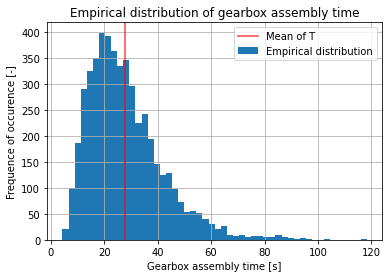

In [172]:
# Plot
plt.hist(T,bins=50, label="Empirical distribution");
plt.axvline(x=np.mean(T), color='r', label="Mean of T", alpha=0.75)
plt.title("Empirical distribution of gearbox assembly time")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Frequence of occurence [-]")
plt.legend()
plt.grid(True)
plt.show();

Nous remarquons que la valeur de la moyenne empirique est proche de celle calculée. 


------------------------------------------------------------------------------------------------------


3. a) Load simulated data from the file "sample.csv". Fit the exponential, gamma and chi-square distributions and estimate their parameters by log-likelihood maximization. Select the best non-Gaussian statistical distribution for  $T$. Justify your choice.

Rem: if you use scipy, set the location parameter to zero with option 'floc=0'.

------------------------------------------------------------------------------------------------------

In [173]:
data = pd.read_csv("sample.csv").to_numpy()
x = np.arange(0,np.max(data)+1)

# Calculs par Log Likelihood
[_, expon_scale] = sc.expon.fit(data,floc=0)
[gamma_alpha,_,gamma_beta] = sc.gamma.fit(data,floc=0)
[chi2_alpha,_,chi2_beta] = sc.chi2.fit(data,floc=0)

# Creation des pdfs
expon_pdf_data = sc.expon.pdf(np.sort(data[:,0]),loc=0,scale=expon_scale)
gamma_pdf_data = sc.gamma.pdf(np.sort(data[:,0]), gamma_alpha, loc=0, scale=gamma_beta)
chi2_pdf_data = sc.chi2.pdf(np.sort(data[:,0]),chi2_alpha, loc=0, scale=chi2_beta)

expon_pdf = sc.expon.pdf(x,loc=0,scale=expon_scale)
gamma_pdf = sc.gamma.pdf(x, gamma_alpha, loc=0, scale=gamma_beta)
chi2_pdf = sc.chi2.pdf(x,chi2_alpha, loc=0, scale=chi2_beta)

# calcul du log-likelihood
expon_llh = np.sum(np.log(expon_pdf_data))
gamma_llh = np.sum(np.log(gamma_pdf_data))
chi2_llh = np.sum(np.log(chi2_pdf_data))

print("Log-likelihood exponential", expon_llh)
print("Log-likelihood gamma", gamma_llh)
print("Log-likelihood chi-square", chi2_llh)

Log-likelihood exponential -21646.71467412739
Log-likelihood gamma -19655.5821797604
Log-likelihood chi-square -19655.58217986642


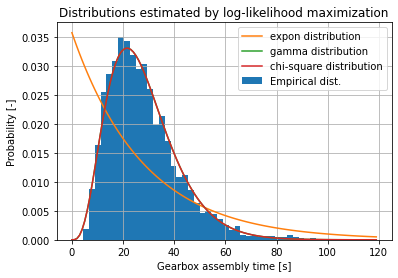

In [174]:
# plot des pdfs
plt.hist(data,bins=50,density=True, label="Empirical dist.")
plt.plot(x, expon_pdf,label="expon distribution")
plt.plot(x, gamma_pdf, label="gamma distribution")
plt.plot(x, chi2_pdf, label="chi-square distribution")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Probability [-]")
plt.legend()
plt.title("Distributions estimated by log-likelihood maximization")
plt.grid(True)
plt.show();

Les distributions gamma et chi-square sont identiques, ce qui est attendu vu que la chi² est un cas particulier de la gamma. Les paramètres d'échelle permettent d'égaler les deux.  
Nous écartons la distribution exponentielle, qui ne maximise pas la vraisemblance, et choisissons la distribution gamma. 

b) During the lectures, we have seen that the chi-square distribution has only one single parameter (the number of degrees of freedom). In Scipy, we find two other parameters location "loc" and scale "scale". Why? 

Ces paramètres permettent de décaler et/ou mettre à l'échelle la distribution.  
On a que `chi2.pdf(x, df, loc, scale)` est équivalent à `chi2.pdf(y, df) / scale` avec `y = (x - loc) / scale`.


------------------------------------------------------------------------------------------------------

c) Compare the empirical distribution with the distribution you chose at 3a). For this purpose, plot an histogram of  durations and add the probability density function (pdf) that you have selected for modelling the random variable.

------------------------------------------------------------------------------------------------------

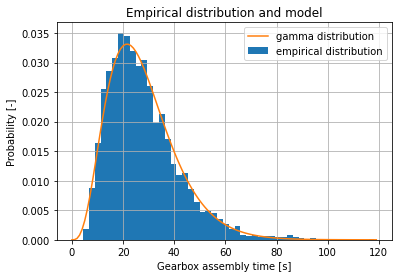

In [175]:
plt.hist(data,bins=50,density=True, label="empirical distribution")
plt.plot(x,gamma_pdf, label="gamma distribution")
plt.legend()
plt.title("Empirical distribution and model")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Probability [-]")
plt.grid(True)
plt.show();

------------------------------------------------------------------------------------------------------

4. We want to fit a Weibull distribution to $T$. The density, $f(t)$, depends upon two parameters $\alpha>0$ and $\lambda>0$ and is given by:

$$ f(t)=\lambda \alpha t^{\alpha-1} \exp(-\lambda t^\alpha) $$

a) Write two functions: one for the density and one that computes the log-likelihood of a sample of durations for this distribution. Test this function on the simulated dataset and for $\alpha=1$ and $\lambda=\frac{1}{28}$

------------------------------------------------------------------------------------------------------

In [176]:
Weibull_pdf = lambda t, a, l : l*a*np.power(t,a-1)*np.exp(-l*np.power(t,a))

def log_likelihood_Weibull(alpha,lambd,data):
    y =  np.log(Weibull_pdf(data,alpha,lambd))
    return float(np.sum(y))

print("log likelihood de Weibull : ",log_likelihood_Weibull(1,1/28,data))

log likelihood de Weibull :  -21646.72462090425


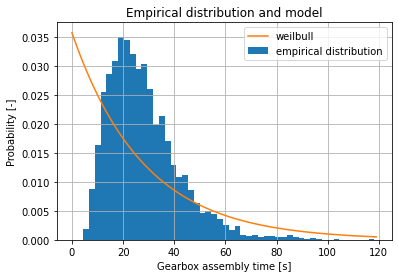

In [177]:
# plot
plt.hist(data,bins=50,density=True, label="empirical distribution")
plt.plot(Weibull_pdf(x,1,1/28), label="weilbull")
plt.legend()
plt.title("Empirical distribution and model")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Probability [-]")
plt.grid(True)
plt.show();

Les paramètres proposés ne semblent pas convenir pour estimer la distribution empirique.

------------------------------------------------------------------------------------------------------

b) Maximize the log-likelihood to find estimates $\hat{\alpha}$ and $\hat{\lambda}$. Next compare the log-likelihood with those computed previously. Is this model better?

Hint: use the "scipy.optimize" package and the function "minimize". To avoid adding constraints, you can do a change of variables: $\alpha=\exp(a)$ and $\lambda=\exp(b)$. The function "minimize" may send back a warning (division by zero in log) but converges well to the solution.

------------------------------------------------------------------------------------------------------

In [178]:
from scipy import optimize

def opti_weibull(parameters,data):
    a,b = parameters
    ea,eb= np.exp(parameters)
    y = np.log(data)*(ea-1)-eb*np.power(data,ea)+ a + b
    return -float(np.sum(y))

ab0 = np.log([1,1/28])

alpha_mle, lambda_mle = np.exp(optimize.minimize(opti_weibull,ab0,data).x)

print("alpha MLE = ",alpha_mle)
print("lambda MLE = ",lambda_mle)
print("log likelihood de Weibull après optimisation = ",log_likelihood_Weibull(alpha_mle,lambda_mle,data))
print("Log-likelihood exponential", expon_llh)
print("Log-likelihood gamma", gamma_llh)
print("Log-likelihood chi-square", chi2_llh)

alpha MLE =  2.121512401654567
lambda MLE =  0.0006555363037711434
log likelihood de Weibull après optimisation =  -19878.727305049444
Log-likelihood exponential -21646.71467412739
Log-likelihood gamma -19655.5821797604
Log-likelihood chi-square -19655.58217986642


Grace au critère du loglikelihood on constate que la Weilbull est moins adapté au fit des données par rapport à la gamma et à la chisquare
En effet la valeur du loglikelihood de weilbull est inférieure à celle de la gamma et de la chi-square

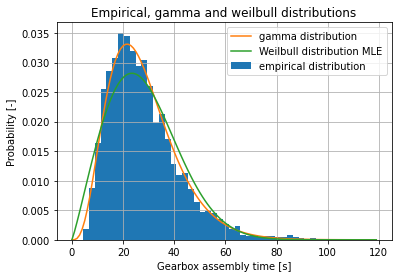

In [179]:
#plot
weilbull_pdf = Weibull_pdf(x,alpha_mle,lambda_mle)
plt.hist(data,bins=50,density=True,label="empirical distribution")
plt.plot(x, gamma_pdf, label="gamma distribution")
plt.plot(weilbull_pdf, label="Weilbull distribution MLE")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Probability [-]")
plt.legend()
plt.title("Empirical, gamma and weilbull distributions")
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------------------

c) The expectation and variance of the Weibull distribution are 
$$ \mathbb{E}(T)=\lambda^{-\frac{1}{\alpha}}\Gamma(\frac{1}{\alpha}+1) $$

$$ \mathbb{V}(T)=\lambda^{-\frac{2}{\alpha}} \left(  \Gamma(\frac{2}{\alpha}+1) -\Gamma(\frac{1}{\alpha}+1)^2  \right) $$

Estimate $\alpha$  and $\lambda$ by the methods of moments. Next calculate the log-likelihood with these estimates and compare with these obtained by log-likelihood maximization. Is the result surprising ?

Hint: use the scipy.optimize package and the function "root". The gamma function is scipy.special.gamma(z)

------------------------------------------------------------------------------------------------------

In [180]:
from scipy import special

def method_of_moments(y) :
    [a, l] = y
    x = np.arange(0,np.max(data)+1)
    esperance = np.dot(x, Weibull_pdf(x, a, l))
    variance = np.dot(x**(2), Weibull_pdf(x, a, l)) - esperance**2
    mu = l**(-1/a)*special.gamma((1/a) + 1)
    var = l**(-2/a)*(special.gamma((1/a) + 1) - (special.gamma((1/a) + 1))**2)
    return [esperance - mu, variance - var]

x0 = np.array([1,1/28]) # Initial guess
[alpha_mme, lambda_mme] = optimize.root(method_of_moments, x0).x #On détermine les paramètres lambda et alpha en égalant
print("alpha = ",alpha_mme)                                      #les variances et espérances par la méthode des moments 
print("lambda = ",lambda_mme)

#Plot des distributions obtenues par la méthode des moments (mme) et par la log-likelihood maximization (mle)
weilbull_pdf_mme = Weibull_pdf(x,alpha_mme,lambda_mme)

alpha =  1.0
lambda =  0.03571428571428571


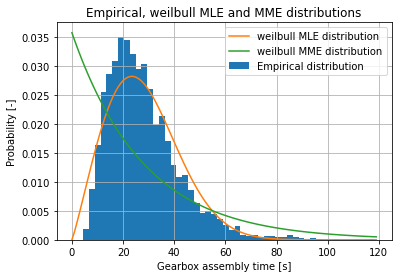

In [181]:
# plot
plt.hist(data,bins=50,density=True,label="Empirical distribution")
plt.plot(weilbull_pdf, label="weilbull MLE distribution")
plt.plot(weilbull_pdf_mme, label="weilbull MME distribution")
plt.legend()
plt.title("Empirical, weilbull MLE and MME distributions")
plt.xlabel("Gearbox assembly time [s]")
plt.ylabel("Probability [-]")
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------------------

5.	Based on the content of the “Self-learning 2”, Bootstrap 1000 times the sample of durations simulated in Question 2 (stored in the file "sample.csv") and compute, the mean, standard deviation and 95% and 90% confidence interval for parameter(s) estimate(s). Plot the empirical distribution of parameter(s).

------------------------------------------------------------------------------------------------------

In [182]:
M = 1000 # Nombre de fois que l'on veut effectuer un bootstrap
alpha_b = np.zeros(M)
beta_b = np.zeros(M)
for m in np.arange(0,M): # On effectue 1000 fois le bootstrap
    dat_b = random.choices(population=data, k=5000) # On rééchantillonne parmi l'échantillon issu de "sample.csv"
    [gamma_alpha,_,gamma_beta] = sc.gamma.fit(dat_b,floc=0) # On détermine les parammètres alpha et beta correspondants 
    alpha_b[m] = gamma_alpha                                # par la log-likelihood maximization
    beta_b[m] = gamma_beta

# Affichage des résultats
print("alpha_mean =", np.mean(alpha_b))
print("beta_mean =", np.mean(beta_b))
print("alpha_std = ", np.std(alpha_b))
print("beta_std = ", np.std(beta_b))
print("Confidence interval alpha 95% : [", np.quantile(alpha_b,q=0.025), ", ",  np.quantile(alpha_b,q=0.975), "]")
print("Confidence interval alpha 90% : [", np.quantile(alpha_b,q=0.05), ", ",  np.quantile(alpha_b,q=0.95), "]")
print("Confidence interval beta 95% : [", np.quantile(beta_b,q=0.025), ", ",  np.quantile(beta_b,q=0.975), "]")
print("Confidence interval beta 90% : [", np.quantile(beta_b,q=0.05), ", ",  np.quantile(beta_b,q=0.95), "]")

alpha_mean = 4.366029669645377
beta_mean = 6.403928449747582
alpha_std =  0.08115848990955464
beta_std =  0.13513514011179778
Confidence interval alpha 95% : [ 4.217599870354984 ,  4.53633525688017 ]
Confidence interval alpha 90% : [ 4.237075289334786 ,  4.501503751818894 ]
Confidence interval beta 95% : [ 6.149529628726961 ,  6.672654388626518 ]
Confidence interval beta 90% : [ 6.179235069661805 ,  6.624681473846566 ]


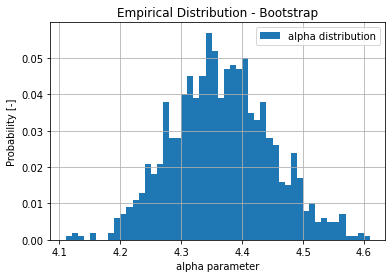

In [183]:
#Plot des distributions empiriques 
plt.hist(alpha_b,bins=50, weights=np.ones(len(alpha_b)) / len(alpha_b), label="alpha distribution") ;
plt.legend()
plt.title("Empirical Distribution - Bootstrap")
plt.xlabel("alpha parameter")
plt.ylabel("Probability [-]")
plt.grid(True)
plt.show();

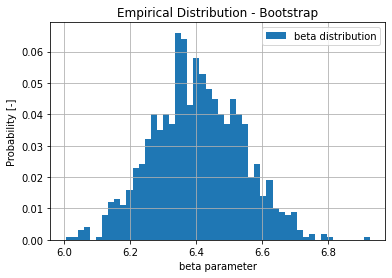

In [184]:
#Plot des distributions empiriques 
plt.hist(beta_b,bins=50, weights=np.ones(len(alpha_b)) / len(alpha_b), label="beta distribution") ;
plt.legend()
plt.title("Empirical Distribution - Bootstrap")
plt.xlabel("beta parameter")
plt.ylabel("Probability [-]")
plt.grid(True)
plt.show()

-----------------------------------------------------------------------------------------------------

6. Using simulated assembling times, determine the probability that assembling 10 gearboxes lasts less than 320 seconds $P(T\leq 320\,sec)$. 

------------------------------------------------------------------------------------------------------

In [185]:
#probabilité que le temps d'assemblage de 10 gearboxes soit <= 320
n = 0
for i in range(0,len(data),10):
    time_sum = np.sum(data[i:i+10])
    if time_sum<=320 :
        n+=1
PT320 = 10*n/(len(data))

print("Probabilité estimée =",PT320)

Probabilité estimée = 0.8441688337667533


------------------------------------------------------------------------------------------------------

7. Is there any alternative to numerical computing in question 6 for approximating  $P(T\leq 320\,sec)$? Please detail your answer and provide an estimate of this probability.

------------------------------------------------------------------------------------------------------

Nous savons que si $X_i$ $\sim$ $\Gamma(\alpha_i, \beta)$, alors $Z = \sum_i X_i$ $\sim$ $\Gamma(\sum_i \alpha_i, \beta)$. Par conséquent, $T = \sum_{i=0}^{10} T_i \sim \Gamma(10\alpha, \beta)$. On sait également que $P(T \leq 320) = F_{\Gamma(10\alpha,\beta)}(320)$, la fonction de répartition d'une gamma évaluée en $x=320$.

In [186]:
proba = sc.gamma.cdf(320,10*gamma_alpha,scale=gamma_beta)
print("Probabilité estimée =",proba)

Probabilité estimée = 0.8238603994576112
